In [1]:
import boto3
import json
from pprint import pprint
import awswrangler as wr
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [20]:
session = boto3.session.Session(profile_name='private', region_name='eu-west-1')

### Query data

In [21]:
def read_meter(row: pd.Series) -> pd.Series:
    if not pd.isna(row['gasmeasurement']):
        row['gas'] = row['gasmeasurement']['meter']
    if not pd.isna(row['electricitymeasurement']):
        row['elec'] = row['electricitymeasurement']['meter']
    return row

In [22]:
clients = {
    "HL - Huurders": "ENn2zWN9smgY2hisWld65HJgn22ung6i", 
    "HL - Kopers": "JYv2oupDzl9BHgZUCEFeV8OPKfjBr3AF", 
    "HL - woCom": "1bc97b4a-45ca-46a2-ac20-937d4c45d03a"
}

In [23]:
date = '2024-01-10'

In [24]:
p4_day_query = f"SELECT activationkey, gasmeasurement, electricitymeasurement FROM swa.p4day WHERE date = '{date}' AND clientid in {tuple(clients.values())}"
df = wr.athena.read_sql_query(
    sql=p4_day_query,
    database="swa",
    s3_output="s3://gbstraathof-athena-queries/",
    workgroup="primary",
    boto3_session=session,
)

In [25]:
df = df.apply(read_meter, axis=1)
jan11 = df[['activationkey', 'gas', 'elec']].copy()

In [26]:
date = '2024-01-09'

In [27]:
p4_day_query = f"SELECT activationkey, gasmeasurement, electricitymeasurement FROM swa.p4day WHERE date = '{date}' AND clientid in {tuple(clients.values())}"
df = wr.athena.read_sql_query(
    sql=p4_day_query,
    database="swa",
    s3_output="s3://gbstraathof-athena-queries/",
    workgroup="primary",
    boto3_session=session,
)

In [28]:
df = df.apply(read_meter, axis=1)
jan10 = df[['activationkey', 'gas', 'elec']].copy()

In [29]:
energy = pd.merge(jan10, jan11, on='activationkey', how='inner', suffixes=['10', '11'])
energy.replace(np.nan, 0, inplace=True)

In [30]:
energy['gas'] = energy['gas11'] - energy['gas10']
energy['elec'] = energy['elec11'] - energy['elec10']
energy['energy'] = energy['elec'] + (energy['gas'] * 9.77)
energy = energy[energy['energy'] >= 0].copy()
# energy = energy[energy['energy'] < 500]

In [62]:
energy[energy['energy'] >= 500]

,activationkey,gas10,elec10,gas11,elec11,gas,elec,energy
593,GXE9THE,13591.585,21515.411,13648.071,21544.103,56.486,28.692,580.56022
696,PTLBLNS,25307.538,159613.817,25350.582,159705.199,43.044,91.382,511.92188
1387,X8V5LGS,10005.461,24935.594,10108.462,24946.986,103.001,11.392,1017.71177
1446,NSQ9YFH,15673.040,40353.561,15727.180,40398.075,54.140,44.514,573.46180


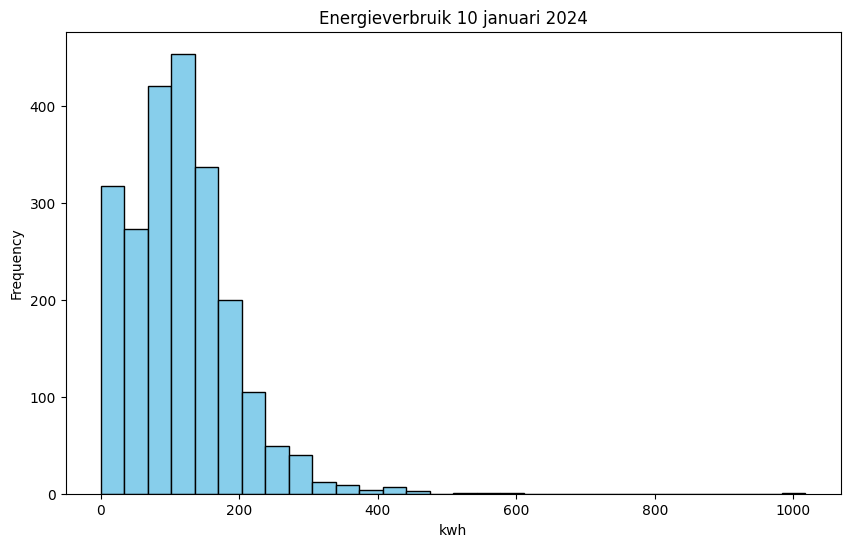

In [63]:
plt.figure(figsize=(10, 6))
plt.hist(energy['energy'], bins=30, color='skyblue', edgecolor='black')
plt.title("Energieverbruik 10 januari 2024")
plt.xlabel('kwh')
plt.ylabel('Frequency')
plt.show()

### Combine with household data

In [71]:
households = pd.read_csv('../data/spa_households.csv', sep=';')
households.rename(columns={'activation_code': 'activationkey'}, inplace=True)
households['date_of_activation'] = pd.to_datetime(households['date_of_activation'], format='ISO8601', utc=False).dt.tz_localize(None)

In [72]:
householdenergy = pd.merge(energy, households[['activationkey', 'date_of_activation', 'gas_ean','house_type', 'housing_corporation', 'zipcode', 'postcode', 'bouwjaar', 'client_group', 'label', 'opp']], on='activationkey', how='left')
householdenergy = householdenergy[householdenergy['date_of_activation'] < datetime(2024,1,10)]
# householdenergy = householdenergy[['energy', 'postcode', 'bouwjaar']]
householdenergy = householdenergy[householdenergy['energy'] > 1]

In [73]:
householdenergy.to_csv('../data/combined_energy_10jan2024.csv', sep=';', index=False)

In [74]:
oppervlaktes = {
    '< 100m2': lambda x: x < 100,
    '100-120 m2': lambda x: 100 <= x < 120,
    '120-150 m2': lambda x: 120 <= x < 150,
    '150-200 m2': lambda x: 150 <= x < 200,
    '> 200m2': lambda x: x >= 200,
}
def oppervlak(row: pd.Series) -> pd.Series:
    opp = int(row['opp'])
    for o, f in oppervlaktes.items():
        if f(opp):
            row['oppervlak'] = o
            return row    

In [75]:
householdenergy = householdenergy.apply(oppervlak, axis=1)

In [81]:
housing_types = {
    'Corner house': 'hoekhuis',
    'Detached house': 'vrijstaand',
    'Semi-detached house': '2 onder 1 kap',
    'Terraced house': 'tussenwoning',
    'apartment': 'appartement',
    'cornerhouse': 'hoekhuis',
    'detached': 'vrijstaand',
    'rowhouse': 'tussenwoning',
    'semi-detached': '2 onder 1 kap',
}
householdenergy['house_type'] = householdenergy['house_type'].replace(housing_types)

#### Segmentation on...
oppervlak, client_group, housing_corporation, house_type, bouwjaar, label

In [101]:
per = (
    householdenergy.groupby('label')['energy']
    .agg(['count', 'sum'])
)
pd.DataFrame(per)

,count,sum
label,,
A,433,43528.66750
A+,1,56.81968
A++,6,235.02700
A+++,9,286.12100
B,293,35393.45239
C,586,74202.26191
D,198,30539.37514
E,51,7154.23007
F,164,23940.84526


## May 2025
#### segment on zipcode 6 and for top/bottom 100 users

In [85]:
per = (
    householdenergy.groupby('zipcode')['energy']
    .agg(['count', 'sum'])
)
per['average'] = per['sum'] / per['count']
pd.DataFrame(per).to_csv('../data/20240110_average_zip6.csv')

In [86]:
top100 = householdenergy.sort_values(by='energy', ascending=False).iloc[:100, :]

In [87]:
per = (
    top100.groupby('oppervlak')['energy']
    .agg(['count', 'sum'])
)
per['average'] = per['sum'] / per['count']
pd.DataFrame(per)

,count,sum,average
oppervlak,,,
120-150 m2,2,555.40074,277.700370
150-200 m2,12,3378.79163,281.565969
< 100m2,1,511.92188,511.921880
> 200m2,85,27576.71537,324.431946


In [88]:
per = (
    top100.groupby('zipcode')['energy']
    .agg(['count', 'sum'])
)
per['average'] = per['sum'] / per['count']
pd.DataFrame(per).to_csv('../data/20240110_top100_average_zip6.csv')

In [89]:
bottom100 = householdenergy.sort_values(by='energy', ascending=True).iloc[:100, :]

In [91]:
per = (
    bottom100.groupby('oppervlak')['energy']
    .agg(['count', 'sum'])
)
per['average'] = per['sum'] / per['count']
pd.DataFrame(per)

,count,sum,average
oppervlak,,,
100-120 m2,17,261.46507,15.380298
120-150 m2,20,361.15311,18.057655
150-200 m2,25,386.80927,15.472371
< 100m2,20,383.75943,19.187971
> 200m2,18,339.10428,18.839127


In [92]:
per = (
    bottom100.groupby('zipcode')['energy']
    .agg(['count', 'sum'])
)
per['average'] = per['sum'] / per['count']
pd.DataFrame(per).to_csv('../data/20240110_bottom100_average_zip6.csv')

In [93]:
withean = householdenergy[~pd.isna(householdenergy['gas_ean'])]
noean = householdenergy[pd.isna(householdenergy['gas_ean'])]
print(f'Total energy usage for housholds without a gas EAN {len(noean)}: {noean['energy'].sum():.2f}')
print(f'Total energy usage of top 100 users with gas EAN: {withean.sort_values(by='energy', ascending=False).iloc[:100, :]['energy'].sum():.2f}')
print(f'Total energy usage of bottom 100 users with gas EAN: {withean.sort_values(by='energy', ascending=True).iloc[:100, :]['energy'].sum():.2f}')

Total energy usage for housholds without a gas EAN 112: 5065.29
Total energy usage of top 100 users with gas EAN: 32022.83
Total energy usage of bottom 100 users with gas EAN: 2475.35


#### Investigate the 2 < 100m2 in the top 100

In [54]:
top100[top100['oppervlak'] == '< 100m2']

,activationkey,gas10,elec10,gas11,elec11,gas,elec,energy,date_of_activation,gas_ean,house_type,housing_corporation,zipcode,postcode,bouwjaar,client_group,label,opp,oppervlak
696,PTLBLNS,25307.538,159613.817,25350.582,159705.199,43.044,91.382,511.92188,2021-11-06,8.717177e+17,2 onder 1 kap,Koop,5595CK,5595.0,tot 1950,Leende,NaN,97.0,< 100m2


In [56]:
households[households['activationkey'].isin(['PTLBLNS', 'WE68WAF'])]

,activationkey,id,account_status,client_id,date_of_activation,gas_ean,electricity_ean,build_year,square_meters,house_type,...,housing_corporation,client_group,postcode,bouwjaar,full_address,active,bouwjaar_addr,label,opp,Huisnummertoevoeging
4756,PTLBLNS,04fed75f-64da-460f-b3e0-185d39a817f6,Active,6a4e7955-aca0-4dab-8a13-0a6adb014b57,2021-11-06,8.717177e+17,8.716879e+17,1910.0,100.0,semi-detached,...,Koop,Leende,5595.0,tot 1950,5595CK116A,True,1910.0,NaN,97.0,NaN


In [57]:
households.loc[4756, :]

activationkey                                         PTLBLNS
id                       04fed75f-64da-460f-b3e0-185d39a817f6
account_status                                         Active
client_id                6a4e7955-aca0-4dab-8a13-0a6adb014b57
date_of_activation                        2021-11-06 00:00:00
gas_ean                                  871717710000357504.0
electricity_ean                          871687940008650624.0
build_year                                             1910.0
square_meters                                           100.0
house_type                                      semi-detached
heating_type                                              NaN
gas_connection                                            NaN
gas_or_induction                                          NaN
water_heating_type                                        NaN
zipcode                                                5595CK
house_number                                            116.0
house_nu

In [94]:
top200 = householdenergy.sort_values(by='energy', ascending=False).iloc[:200, :]

In [95]:
per = (
    top200.groupby('oppervlak')['energy']
    .agg(['count', 'sum'])
)
per['average'] = per['sum'] / per['count']
pd.DataFrame(per)

,count,sum,average
oppervlak,,,
100-120 m2,1,236.69197,236.691970
120-150 m2,4,1012.42919,253.107297
150-200 m2,50,12009.53989,240.190798
< 100m2,1,511.92188,511.921880
> 200m2,144,41125.88989,285.596458


In [98]:
# Remove outlier
top100reduced = householdenergy.sort_values(by='energy', ascending=False).iloc[:101, :]
top100reduced = top100reduced[top100reduced['activationkey'] != 'PTLBLNS']

In [100]:
per = (
    top100reduced.groupby('oppervlak')['energy']
    .agg(['count', 'sum'])
)
per['average'] = per['sum'] / per['count']
pd.DataFrame(per)

,count,sum,average
oppervlak,,,
120-150 m2,2,555.40074,277.700370
150-200 m2,12,3378.79163,281.565969
> 200m2,86,27830.43342,323.609691
